# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

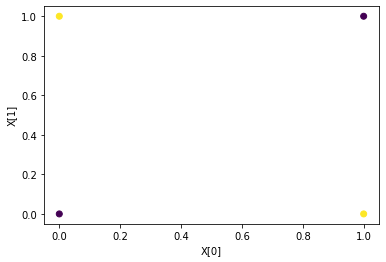

In [3]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [0]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.where(x>0,x,0)

def ReLUD(x):
    return np.where(x>0,1,0)

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.W1.shape[0],self.W1.shape[1]))
        self.b1 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.b1.shape[0]))
        self.W2 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.W2.shape[0],self.W2.shape[1]))
        self.b2 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.b2.shape[0]))

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X.dot(self.W1.T) + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = O1.dot(self.W2.T) + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            loss = -(Y.T.dot(np.log(O2)) + (1-Y).T.dot(np.log(1-O2)))
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 
            #deriv of loss is x-y/(x*(1-x))
            #in vector form it its O2-y/(O2 * (1-O2).T)
            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss
            O2 = O2.reshape(-1,1)
            A2_grad = (O2-Y)/X.shape[0]
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad = O1.T.dot(A2_grad).T
            O1_grad = O1*(1-O1)
            A1_grad = (A2_grad.dot(self.W2.reshape(-1,1).T))*O1_grad
            self.b1_grad: O2 = A1_grad.sum(0)
            self.W1_grad: O2 = (X.T.dot(A1_grad)).T
        return O2, loss

In [5]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[100,-100],[-100,100]])
net.b1 = np.array([-10,-10])
net.W2 = np.array([15,15])
net.b2 = np.array([-5])

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 


net.forward(X, Y, do_backward=True)

(array([[0.00670191],
        [0.9999546 ],
        [0.9999546 ],
        [0.00670191]]), 0.0033849343958812397)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [0]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [0]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1','b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [8]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        orig_grad = getattr(net, param_name + '_grad')
        param[:] = param - orig_grad

0 1.073791615701788
5000 0.0012989665718762208
10000 0.000582266889186053
15000 0.00036746450932549277
20000 0.0002659885444351972
25000 0.00020738267170886912
30000 0.00016940605813180702
35000 0.00014288102281126883
40000 0.00012334952847085912
45000 0.00010839191787670182
50000 9.658432926932294e-05
55000 8.703558951633823e-05
60000 7.91601093643309e-05
65000 7.255762357864555e-05
70000 6.694547103100294e-05
75000 6.211848871106546e-05
80000 5.7924237217594997e-05
85000 5.424713942849232e-05
90000 5.099800829150396e-05
95000 4.810694519207123e-05


In [9]:
net.forward(X, Y, do_backward=True)

(array([[3.01561285e-05],
        [9.99956394e-01],
        [9.99953716e-01],
        [6.20231823e-05]]), 4.551840958891554e-05)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

2
Acc:  1.0


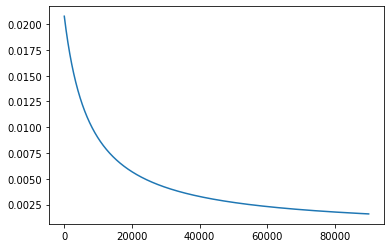

3
Acc:  1.0


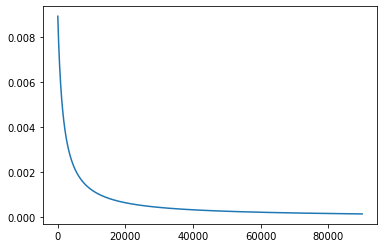

5
Acc:  1.0


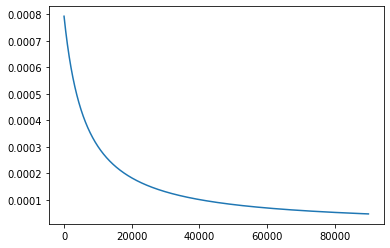

10
Acc:  1.0


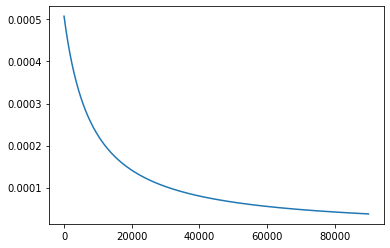

20
Acc:  1.0


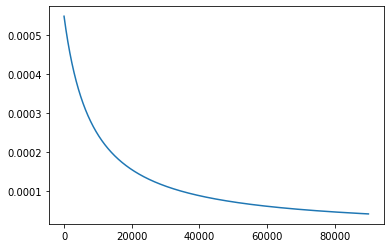

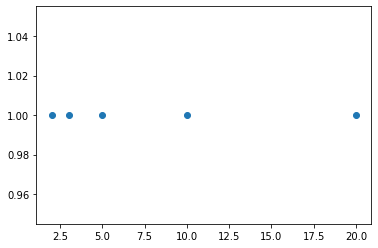

In [10]:
X3 = np.array([
    [1,1,1],
    [1,1,0],
    [1,0,1],
    [1,0,0],
    [0,1,1],
    [0,1,0],
    [0,0,1],
    [0,0,0]      
])
Y3 = np.array([
    [1],
    [0],
    [0],
    [1],
    [0],
    [1],
    [1],
    [0],
])

accuracies = []
for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNet(3, hidden_dim, dtype=np.float64)
    alpha = 1e-1
    story = np.zeros(100000)
    for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        story[i] = loss
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            orig_grad = getattr(net, param_name + '_grad')
            param[:] = param - orig_grad
    res, _ = net.forward(X3,Y3)
    res = np.rint(res)
    out = np.sum(np.abs(Y3 - res))/Y3.shape[0]
    accuracies.append(1-out)
    print(hidden_dim)
    print("Acc: ",1-out)
    plt.plot(np.arange(90000),story[10000:])
    plt.show()
plt.scatter([2,3,5,10,20],accuracies)
plt.show()
#smaller - less powerful but faster to train, lesser weights to tune lesser biases to turn etc
#larger - more powerful but slower to train, more weights and biases to tune
#in general if we have time it is better to make bigger net so it has better chances to adapt to problem
#in our case two hidden neurons net results are sometimes 0.0025 and sometimes 0.34 loss when bigger nets achive something around 1e-5
#but still something bigger than 3 hidden neurons are overkill 

# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho

In [0]:
class SmallNetR:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.W1.shape[0],self.W1.shape[1]))
        self.b1 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.b1.shape[0]))
        self.W2 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.W2.shape[0],self.W2.shape[1]))
        self.b2 = np.random.normal(loc = 0.0,scale = 0.5,size = (self.b2.shape[0]))

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X.dot(self.W1.T) + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = ReLU(A1)
        # Inputs to neuron in the second layer
        A2 = O1.dot(self.W2.T) + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            loss = -(Y.T.dot(np.log(O2)) + (1-Y).T.dot(np.log(1-O2)))
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 
            #deriv of loss is x-y/(x*(1-x))
            #in vector form it its O2-y/(O2 * (1-O2).T)
            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss
            O2 = O2.reshape(-1,1)
            A2_grad = (O2-Y)/X.shape[0]
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad = O1.T.dot(A2_grad).T
            O1_grad = ReLUD(A1)
            A1_grad = (A2_grad.dot(self.W2.reshape(-1,1).T))*O1_grad
            self.b1_grad: O2 = A1_grad.sum(0)
            self.W1_grad: O2 = (X.T.dot(A1_grad)).T
        return O2, loss

2
0.597545871816491


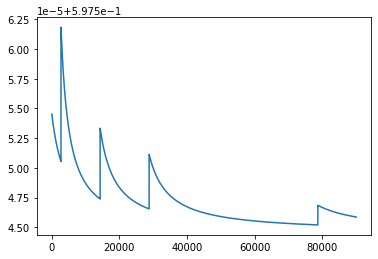

3
0.6931471805599453


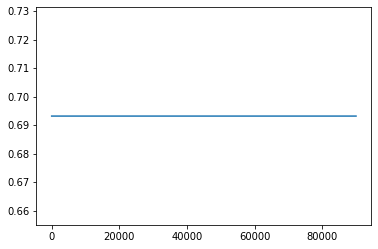

5
1.9858496335253196e-05


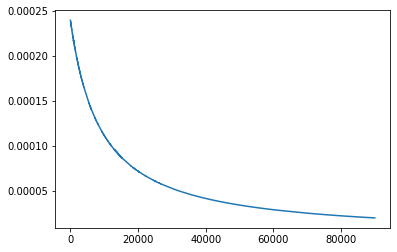

10
8.245913412775707e-06


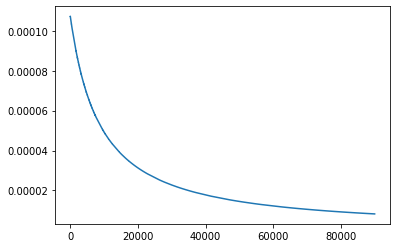

20
7.373068494091266e-06


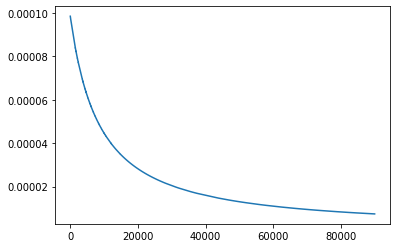

In [12]:
for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNetR(3, hidden_dim, dtype=np.float64)
    alpha = 1e-1
    story = np.zeros(100000)
    for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        story[i] = loss
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            orig_grad = getattr(net, param_name + '_grad')
            param[:] = param - orig_grad
    print(hidden_dim)
    print(story[99999])
    plt.plot(np.arange(90000),story[10000:])
    plt.show()